# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt

# Parameters

In [2]:
tiempo_vida_inicial = 20
tiempo_vida_maximo = 150            #Para que los resultados obtenidos se encuentren ligados a realidad biologica
pasos_integracion = tiempo_vida_maximo- tiempo_vida_inicial           #Definicion de los pasos de integracion de algoritmo   #Tasa de propagacion de daño
coupling_factor = 0.5             #Factor de acoplamiento entre frailty index y gompertz
mortality_rate = 4.3*(10**(-2.3))     #Tasa de mortalidad
condicion_inicial = 0.02

# Gillespie

In [5]:
@njit()
def Gillespie(trp0,tmax, N_total, disease_rate):
    """
    Esta funcion se emplea solamente para hacer la evolución de un paso individual en la celula. Evoluciona no un paso temporal, 
    pero si temporalmente la cantidad de veces que pueda evolucionar antes del tmax en una corrida
    """
    t,N, died =trp0 

    while t < tmax and not died :
        s_1 =  alpha_damage_propagation*N + disease_rate*N_total
        s_2 = mortality_rate*((N/N_total)**(coupling_factor/alpha_damage_propagation))
        S_T = s_1 + s_2 

        τ = (-1/S_T)*np.log(np.random.rand())
        x = np.random.rand()

        if x <= (s_1)/S_T:
            N += 1
        else: 
            died = True
            break
        t+=τ
    return np.array([t,N, died]) 
@njit()
def Estado_celula(X0,tiempos, N_total, disease_rate):
    
    X = np.empty((len(tiempos),len(X0)))
    X[:] = np.nan
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i], N_total, disease_rate)
        if X[i][2]:
            break
    return X

# Stochastic Simulation

In [6]:
N_total_steps = [200, 250, 300, 350, 400]
disease_rate_steps = [0.001]
simulaciones = np.empty((len(N_total_steps),len(disease_rate_steps)), dtype=object)

alpha_damage_propagation = 0.5
for idx_D, D in enumerate(disease_rate_steps):
    for idx_N, N in enumerate(N_total_steps):
        x0 = np.array([20., int(N*condicion_inicial), False])    #Condicion Inicial
        num_cel = 1*(10**5) #Cantidad de personas que se estan simulando
        celulas = np.array([Estado_celula(x0,np.arange(tiempo_vida_inicial,tiempo_vida_maximo,1.), N,D ) for i in tqdm(range(num_cel))])
        simulaciones[idx_N][idx_D] = celulas

 57%|█████▋    | 57025/100000 [00:20<00:01, 33219.48it/s]

KeyboardInterrupt: 

In [5]:
frailty_index_promedio = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)
gompertz_law_promedio = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)
for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        curva_promedio_stochastic_model = np.zeros((len(simulaciones[i][j][0])))
        curva_promedio_gompertz = np.zeros((len(simulaciones[i][j][0])))
        suma = 0
        for k in tqdm(np.arange((len(simulaciones[i][j][0])))):
            curva_promedio_gompertz[k] = suma
            muertos = (np.nansum(simulaciones[i][j][:,k,2]))
            suma += muertos
            
            promedio1 = np.nanmean(simulaciones[i][j][:,k,1])/N_total_steps[i]
            curva_promedio_stochastic_model[k] = promedio1
        gompertz_law_promedio[i][j] = curva_promedio_gompertz
        frailty_index_promedio[i][j] = curva_promedio_stochastic_model


100%|██████████| 130/130 [00:00<00:00, 213.76it/s]


In [6]:
def f(x, alpha_damage_propagation, disease_rate, t=None):
    return (alpha_damage_propagation*x + disease_rate)

In [7]:
def Runke_Kutta_Method(temporal_evolution:list, disease_rate):
    x = condicion_inicial                                        #Initial condition     
    frailty_index = np.empty((len(temporal_evolution)))
    for index, t in enumerate(temporal_evolution):
        frailty_index[index] = x
        k1 = h*f(x, alpha_damage_propagation, disease_rate, t=t)
        k2 = h*f(x+0.5*k1, alpha_damage_propagation, disease_rate, t=t +0.5*h)
        x += k2

    gompertz_law = mortality_rate*(frailty_index**(coupling_factor/alpha_damage_propagation))
    return frailty_index, gompertz_law, temporal_evolution

In [8]:

h = (tiempo_vida_maximo-tiempo_vida_inicial)/pasos_integracion                                         #Pasos de integracion
temporal_evolution = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,h) 
frailty_index_differential_equation,gompertz_law_differential_equation,temporal_evolution_differential_equation = Runke_Kutta_Method(temporal_evolution, disease_rate_steps[0])

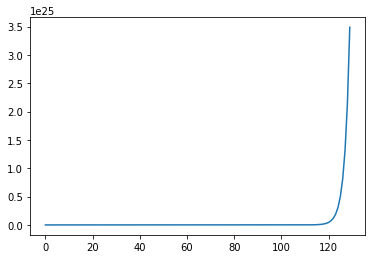

In [9]:
plt.plot(frailty_index_differential_equation)

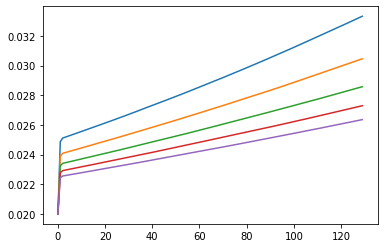

In [11]:
plt.plot(frailty_index_promedio[0][0])
plt.plot(frailty_index_promedio[1][0])
plt.plot(frailty_index_promedio[2][0])
plt.plot(frailty_index_promedio[3][0])
plt.plot(frailty_index_promedio[4][0])


# Strehler Mildvan Parameters

In [16]:
t = np.arange(tiempo_vida_inicial,tiempo_vida_maximo,1.)
strehler_mildvan_correlation = np.empty((len(simulaciones), len(simulaciones[0])), dtype = object)

for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        valores_beta_R = np.empty((2), dtype = object)
        data = gompertz_law_promedio[i][j]
        derivative_process = dxdt(data, t, kind="finite_difference", k=1)
        beta_values = derivative_process/data
        R_values = data/np.e**(beta_values*t)

        valores_beta_R[0] = beta_values
        valores_beta_R[1] = R_values

        strehler_mildvan_correlation[i][j] = valores_beta_R


/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_45277/4093834566.py:9: RuntimeWarning: divide by zero encountered in true_divide
  beta_values = derivative_process/data
/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_45277/4093834566.py:9: RuntimeWarning: invalid value encountered in true_divide
  beta_values = derivative_process/data


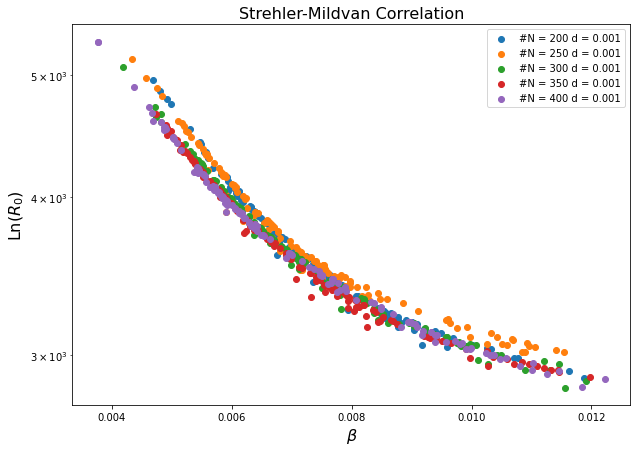

In [22]:
plt.figure(figsize=(10,7))
plt.title(r"Strehler-Mildvan Correlation", fontsize = 16)
inicial = 3
final = -1

for i in range(len(frailty_index_promedio)):
    for j in range(len(frailty_index_promedio[0])):
        plt.scatter(strehler_mildvan_correlation[i][j][0][inicial:final], strehler_mildvan_correlation[i][j][1][inicial:final], label = f"#N = {N_total_steps[i]} d = {disease_rate_steps[j]}")

plt.xlabel(r"$\beta$", fontsize = 16)
plt.ylabel(r"Ln($R_0$)", fontsize = 16)
plt.yscale("log")
plt.legend()